**EirGrid-Scraping**

### Co2 Forecast 

This Python script is designed to fetch CO2 data from a specific API. It includes the following key components:

1. **Round Down Time Function (`round_down_time`)**
   - Rounds down the current time to the nearest half-hour, accommodating the data's 30-minute availability intervals.

2. **URL Creation Function (`create_url`)**
   - Constructs the API URL using formatted start and end times and a chosen region.

3. **Time and Region Settings**
   - Sets the current time (`now`), applies the round-down function, and calculates the end time as 24 hours from the current time.
   - Selects a region (example: 'ROI') for data fetching.

4. **API Request**
   - Generates the API URL and performs a GET request to retrieve the data.
   - Stores the response in JSON format.

This script is tailored for accessing time-sensitive environmental data from a designated API endpoint.


In [1]:
from datetime import datetime, timedelta
import requests
from pandas import DataFrame

# data is availble every 30 minutes, so we need to start at the nearest half-hour 
def round_down_time(dt):
    # Round down to the nearest half-ho/ur
    new_minute = 30 if dt.minute >= 30 else 0
    return dt.replace(minute=new_minute, second=0, microsecond=0)

# Function to create the API URL based on the start and end datetimes and the region
def create_url(start_datetime, end_datetime, region):
    start_str = start_datetime.strftime("%Y%m%d%H%M")
    end_str = end_datetime.strftime("%Y%m%d%H%M")
    url = f"https://www.co2.smartgriddashboard.com/api/co2_fc/{start_str}/{end_str}/{region}"
    return url

# Current date and time
now = datetime.now()
# Round down to the nearest half-hour
start_time = round_down_time(now)
# For end time, let's use 24 hours from now
end_time = now.replace(hour=23, minute=59, second=59, microsecond=0) #now + timedelta(days=1)

# Define the region
region = ['ROI', 'NI', 'ALL']

# Create the URL
api_url = create_url(start_time, end_time, region[2])
response = requests.get(api_url)
Rs = response.json()


In [2]:
import pandas as pd
df_carbon_forecast = pd.DataFrame(Rs['Rows'])

# Convert 'EffectiveTime' to datetime and set as index
df_carbon_forecast['EffectiveTime'] = pd.to_datetime(df_carbon_forecast['EffectiveTime'], format='%d-%b-%Y %H:%M:%S')
df_carbon_forecast_indexed = df_carbon_forecast.set_index('EffectiveTime')

# Now you can slice the DataFrame using datetime index
# # For example, to access data at '26-JAN-2024 21:30:00'
# specific_time_data = df_carbon_forecast_indexed.loc['2024-01-26 21:30:00']

# # To access a range of times
# time_range_data = df_carbon_forecast_indexed['2024-01-26 21:00:00':'2024-01-26 22:00:00']

# # Print to see the results
# print(specific_time_data)
# print(time_range_data)

In [3]:
df_carbon_forecast_indexed

,FieldName,Region,Value
EffectiveTime,,,
2024-01-28 16:00:00,CO2_INTENSITY_FORECAST,ALL,151.3842
2024-01-28 16:30:00,CO2_INTENSITY_FORECAST,ALL,157.0552
2024-01-28 17:00:00,CO2_INTENSITY_FORECAST,ALL,176.6748
2024-01-28 17:30:00,CO2_INTENSITY_FORECAST,ALL,175.3173
2024-01-28 18:00:00,CO2_INTENSITY_FORECAST,ALL,180.1700
2024-01-28 18:30:00,CO2_INTENSITY_FORECAST,ALL,181.9601
2024-01-28 19:00:00,CO2_INTENSITY_FORECAST,ALL,183.7465
2024-01-28 19:30:00,CO2_INTENSITY_FORECAST,ALL,188.4471
2024-01-28 20:00:00,CO2_INTENSITY_FORECAST,ALL,196.5663


### Co2 intensity (measured) from day before

In [4]:
import datetime

# Function to round time to the nearest 15 minutes
def round_time(dt):
    # Round minutes to the nearest 15
    new_minute = (dt.minute // 15) * 15
    return dt.replace(minute=new_minute, second=0, microsecond=0)

# Function to format date in your specific format
def format_date(dt):
    return dt.strftime("%d-%b-%Y").lower() + "+" + dt.strftime("%H%%3A%M")

# Current date and time, rounded to the nearest 15 minutes
now = round_time(datetime.datetime.now())

# Start time (same time yesterday, rounded to the nearest 15 minutes)
yesterday = now - datetime.timedelta(days=1)
startDateTime = format_date(yesterday)

# End time (current time, rounded to the nearest 15 minutes)
endDateTime = format_date(now)

# Print formatted start and end times
print("Start Time:", startDateTime)
print("End Time:", endDateTime)


Start Time: 27-jan-2024+16%3A00
End Time: 28-jan-2024+16%3A00


In [5]:
import requests , json

area = ['CO2Stats', 'generationactual', 'co2emission', 'co2intensity', 'interconnection', 'SnspAll', 'frequency', 'demandactual', 'windactual']
region = ['ROI', 'NI', 'ALL']
Rows = []

url = f'http://smartgriddashboard.eirgrid.com/DashboardService.svc/data?area={area[3]}&region={region[2]}&datefrom={startDateTime}&dateto={endDateTime}'
response = requests.get(url)
Rs = json.loads(response.text)["Rows"]
for row in Rs:
    Rows.append(row)

df_carbon_intensity_day_before= DataFrame(Rows)

In [6]:
# Convert 'EffectiveTime' to datetime and set as index
df_carbon_intensity_day_before['EffectiveTime'] = pd.to_datetime(df_carbon_intensity_day_before['EffectiveTime'], format='%d-%b-%Y %H:%M:%S')
df_carbon_intensity_indexed = df_carbon_intensity_day_before.set_index('EffectiveTime')

In [7]:
import pandas as pd
import numpy as np


# Interpolate NaN values, except for the last NaN
df_carbon_int_interp = df_carbon_intensity_indexed.interpolate()

# Reverse the DataFrame
df_reversed = df_carbon_int_interp.iloc[::-1]

# Find the first valid index in the reversed DataFrame, which corresponds to the last NaN before non-NaN values
last_nan_index_before_non_nan = df_reversed['Value'].first_valid_index()


# Select rows up to the row before the last NaN
df_carbon_intensity_recent = df_carbon_int_interp.loc[:last_nan_index_before_non_nan]

/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_1964/2998555976.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_carbon_int_interp = df_carbon_intensity_indexed.interpolate()


In [8]:
last_nan_index_before_non_nan

Timestamp('2024-01-28 16:00:00')

In [9]:
import json

# Calculate mean, min, and max
mean_val = df_carbon_intensity_recent['Value'].mean()
min_val = df_carbon_intensity_recent['Value'].min()
max_val = df_carbon_intensity_recent['Value'].max()

# Create a dictionary with these values
co2_stats_prior_day = {
    "mean": mean_val,
    "min": min_val,
    "max": max_val
}

# Convert the dictionary to a JSON string
co2_stats_json_prior_day = json.dumps(co2_stats_prior_day)

print(co2_stats_json_prior_day)


{"mean": 140.39175257731958, "min": 111.0, "max": 173.0}


In [10]:
co2_stats_prior_day['max']

173.0

In [11]:
df_carbon_forecast_indexed

,FieldName,Region,Value
EffectiveTime,,,
2024-01-28 16:00:00,CO2_INTENSITY_FORECAST,ALL,151.3842
2024-01-28 16:30:00,CO2_INTENSITY_FORECAST,ALL,157.0552
2024-01-28 17:00:00,CO2_INTENSITY_FORECAST,ALL,176.6748
2024-01-28 17:30:00,CO2_INTENSITY_FORECAST,ALL,175.3173
2024-01-28 18:00:00,CO2_INTENSITY_FORECAST,ALL,180.1700
2024-01-28 18:30:00,CO2_INTENSITY_FORECAST,ALL,181.9601
2024-01-28 19:00:00,CO2_INTENSITY_FORECAST,ALL,183.7465
2024-01-28 19:30:00,CO2_INTENSITY_FORECAST,ALL,188.4471
2024-01-28 20:00:00,CO2_INTENSITY_FORECAST,ALL,196.5663


In [12]:
df_carbon_forecast_value = df_carbon_forecast_indexed['Value']

carbon_forecast_hourly = df_carbon_forecast_value.resample('1H').mean()

In [13]:
pd.DataFrame(carbon_forecast_hourly)

,Value
EffectiveTime,
2024-01-28 16:00:00,154.21970
2024-01-28 17:00:00,175.99605
2024-01-28 18:00:00,181.06505
2024-01-28 19:00:00,186.09680
2024-01-28 20:00:00,198.60950
2024-01-28 21:00:00,207.39105
2024-01-28 22:00:00,232.07710
2024-01-28 23:00:00,262.53065


In [14]:
def classify_status(value, min_val, max_val):
    if value < min_val:
        return 'low'
    elif value > max_val:
        return 'high'
    else:
        return 'medium'
    
    

In [15]:
df_carbon_forecast_indexed['status_compared_to_yesterday'] = df_carbon_forecast_indexed['Value'].apply(classify_status, args=(co2_stats_prior_day['min'], co2_stats_prior_day['max']))
df_carbon_forecast_indexed['status_compared_to_EU'] = df_carbon_forecast_indexed['Value'].apply(classify_status, args=(250, 500))


In [16]:
df_carbon_forecast_indexed

,FieldName,Region,Value,status_compared_to_yesterday,status_compared_to_EU
EffectiveTime,,,,,
2024-01-28 16:00:00,CO2_INTENSITY_FORECAST,ALL,151.3842,medium,low
2024-01-28 16:30:00,CO2_INTENSITY_FORECAST,ALL,157.0552,medium,low
2024-01-28 17:00:00,CO2_INTENSITY_FORECAST,ALL,176.6748,high,low
2024-01-28 17:30:00,CO2_INTENSITY_FORECAST,ALL,175.3173,high,low
2024-01-28 18:00:00,CO2_INTENSITY_FORECAST,ALL,180.1700,high,low
2024-01-28 18:30:00,CO2_INTENSITY_FORECAST,ALL,181.9601,high,low
2024-01-28 19:00:00,CO2_INTENSITY_FORECAST,ALL,183.7465,high,low
2024-01-28 19:30:00,CO2_INTENSITY_FORECAST,ALL,188.4471,high,low
2024-01-28 20:00:00,CO2_INTENSITY_FORECAST,ALL,196.5663,high,low


In [17]:
import pandas as pd

# Assuming df is your DataFrame

def color_status(val):
    if val == 'low':
        color = 'green'
    elif val == 'medium':
        color = 'orange'
    else:  # high
        color = 'red'
    return f'background-color: {color}'

df_styled = df_carbon_forecast_indexed.style.applymap(color_status, subset=['status_compared_to_yesterday', 'status_compared_to_EU'])
df_styled


/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_1964/3058254539.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_styled = df_carbon_forecast_indexed.style.applymap(color_status, subset=['status_compared_to_yesterday', 'status_compared_to_EU'])


,FieldName,Region,Value,status_compared_to_yesterday,status_compared_to_EU
EffectiveTime,,,,,
2024-01-28 16:00:00,CO2_INTENSITY_FORECAST,ALL,151.384200,medium,low
2024-01-28 16:30:00,CO2_INTENSITY_FORECAST,ALL,157.055200,medium,low
2024-01-28 17:00:00,CO2_INTENSITY_FORECAST,ALL,176.674800,high,low
2024-01-28 17:30:00,CO2_INTENSITY_FORECAST,ALL,175.317300,high,low
2024-01-28 18:00:00,CO2_INTENSITY_FORECAST,ALL,180.170000,high,low
2024-01-28 18:30:00,CO2_INTENSITY_FORECAST,ALL,181.960100,high,low
2024-01-28 19:00:00,CO2_INTENSITY_FORECAST,ALL,183.746500,high,low
2024-01-28 19:30:00,CO2_INTENSITY_FORECAST,ALL,188.447100,high,low
2024-01-28 20:00:00,CO2_INTENSITY_FORECAST,ALL,196.566300,high,low


In [19]:
df


,FieldName,Region,Value,status_compared_to_yesterday,status_compared_to_EU
EffectiveTime,,,,,
2024-01-28 16:00:00,CO2_INTENSITY_FORECAST,ALL,151.3842,medium,low
2024-01-28 16:30:00,CO2_INTENSITY_FORECAST,ALL,157.0552,medium,low
2024-01-28 17:00:00,CO2_INTENSITY_FORECAST,ALL,176.6748,high,low
2024-01-28 17:30:00,CO2_INTENSITY_FORECAST,ALL,175.3173,high,low
2024-01-28 18:00:00,CO2_INTENSITY_FORECAST,ALL,180.1700,high,low
2024-01-28 18:30:00,CO2_INTENSITY_FORECAST,ALL,181.9601,high,low
2024-01-28 19:00:00,CO2_INTENSITY_FORECAST,ALL,183.7465,high,low
2024-01-28 19:30:00,CO2_INTENSITY_FORECAST,ALL,188.4471,high,low
2024-01-28 20:00:00,CO2_INTENSITY_FORECAST,ALL,196.5663,high,low


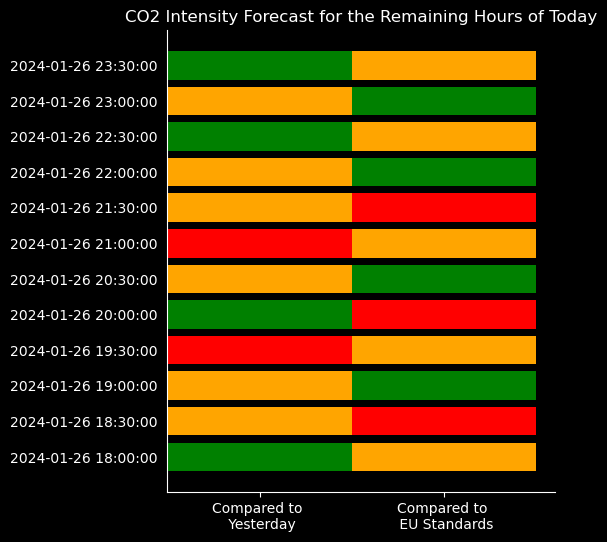

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

data = {
    'EffectiveTime': [
        '2024-01-26 18:00:00', '2024-01-26 18:30:00',
        '2024-01-26 19:00:00', '2024-01-26 19:30:00',
        '2024-01-26 20:00:00', '2024-01-26 20:30:00',
        '2024-01-26 21:00:00', '2024-01-26 21:30:00',
        '2024-01-26 22:00:00', '2024-01-26 22:30:00',
        '2024-01-26 23:00:00', '2024-01-26 23:30:00'
    ],
    'status_compared_to_yesterday': [
        'low', 'medium',
        'medium', 'high',
        'low', 'medium',
        'high', 'medium',
        'medium', 'low',
        'medium', 'low'
    ],
    'status_compared_to_EU': [
        'medium', 'high',
        'low', 'medium',
        'high', 'low',
        'medium', 'high',
        'low', 'medium',
        'low', 'medium'
    ]
}

df = pd.DataFrame(data)

# Map status to colors
color_map = {'low': 'green', 'medium': 'orange', 'high': 'red'}

# Create figure and axes
fig, ax = plt.subplots(figsize=(5, 6))

# Plot bars
for i, row in df.iterrows():
    ax.barh(row['EffectiveTime'], 1, color=color_map[row['status_compared_to_yesterday']], edgecolor='none')
    ax.barh(row['EffectiveTime'], 1, left=1, color=color_map[row['status_compared_to_EU']], edgecolor='none')

# Customize plot appearance
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
ax.tick_params(axis='x', colors='white')  # X-axis ticks color
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Remove x-axis ticks
ax.xaxis.set_ticks([])

# Set y-axis labels
ax.set_yticks(df['EffectiveTime'])
ax.set_yticklabels(df['EffectiveTime'], color='white')

# Set title
ax.set_title('CO2 Intensity Forecast for the Remaining Hours of Today', color='white')
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['Compared to \n Yesterday', 'Compared to \n EU Standards'], color='white')

# Show plot
plt.show()


In [27]:
xx=df_carbon_forecast_indexed.reset_index(inplace=False)

In [40]:
xx

,EffectiveTime,FieldName,Region,Value,status_compared_to_yesterday,status_compared_to_EU
0,2024-01-28 16:00:00,CO2_INTENSITY_FORECAST,ALL,151.3842,medium,low
1,2024-01-28 16:30:00,CO2_INTENSITY_FORECAST,ALL,157.0552,medium,low
2,2024-01-28 17:00:00,CO2_INTENSITY_FORECAST,ALL,176.6748,high,low
3,2024-01-28 17:30:00,CO2_INTENSITY_FORECAST,ALL,175.3173,high,low
4,2024-01-28 18:00:00,CO2_INTENSITY_FORECAST,ALL,180.1700,high,low
5,2024-01-28 18:30:00,CO2_INTENSITY_FORECAST,ALL,181.9601,high,low
6,2024-01-28 19:00:00,CO2_INTENSITY_FORECAST,ALL,183.7465,high,low
7,2024-01-28 19:30:00,CO2_INTENSITY_FORECAST,ALL,188.4471,high,low
8,2024-01-28 20:00:00,CO2_INTENSITY_FORECAST,ALL,196.5663,high,low
9,2024-01-28 20:30:00,CO2_INTENSITY_FORECAST,ALL,200.6527,high,low


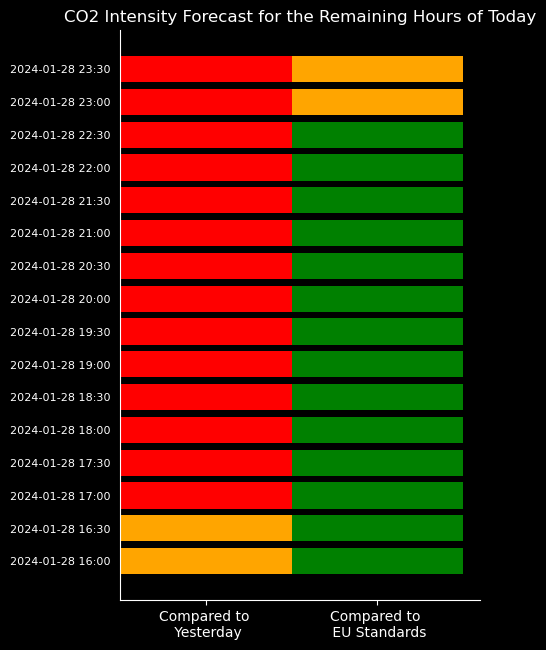

In [44]:
# Assuming df_carbon_forecast_indexed is your DataFrame
df = xx
df['EffectiveTime'] = pd.to_datetime(df['EffectiveTime'])
df.sort_values('EffectiveTime', inplace=True)

# Map status to colors
color_map = {'low': 'green', 'medium': 'orange', 'high': 'red'}

# Create figure and axes
fig, ax = plt.subplots(figsize=(5, 6))

# Plot a bar for each row in the DataFrame.
for i, (index, row) in enumerate(df.iterrows()):
    # Use the index i as the y-coordinate for the bar.
    ax.barh(i, 1, color=color_map[row['status_compared_to_yesterday']], edgecolor='none')
    ax.barh(i, 1, left=1, color=color_map[row['status_compared_to_EU']], edgecolor='none')

# Customize plot appearance.
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
ax.tick_params(axis='x', colors='white')  # X-axis ticks color.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')

# Remove x-axis ticks.
ax.xaxis.set_ticks([])

# Set y-axis labels.
# Convert EffectiveTime to the desired string format and use it as y-tick labels.
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['EffectiveTime'].dt.strftime('%Y-%m-%d %H:%M'), color='white', fontsize=8)

# Ensure everything fits without overlap.
plt.tight_layout()


ax.set_title('CO2 Intensity Forecast for the Remaining Hours of Today', color='white')
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['Compared to \n Yesterday', 'Compared to \n EU Standards'], color='white')

# Display the plot.
plt.show()

In [43]:
i

15

In [34]:
row

EffectiveTime                      2024-01-28 23:30:00
FieldName                       CO2_INTENSITY_FORECAST
Region                                             ALL
Value                                         273.9193
status_compared_to_yesterday                      high
status_compared_to_EU                           medium
Name: 15, dtype: object

In [39]:
row['EffectiveTime']

Timestamp('2024-01-28 23:30:00')

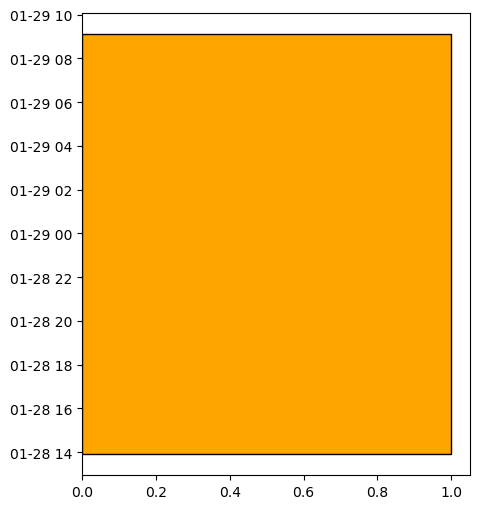

In [38]:
fig, ax = plt.subplots(figsize=(5, 6))
# ax.barh(row['EffectiveTime'], 1, color=color_map[row['status_compared_to_yesterday']], edgecolor='white')
ax.barh(row['EffectiveTime'], 1, color=color_map[row['status_compared_to_EU']], edgecolor='black')

plt.show()

In [42]:
for i, (index, row) in enumerate(df.iterrows()):
    print('i is ',i)
    print('index is ',index)
    print('row is ',row)

i is  0
index is  0
row is  EffectiveTime                      2024-01-28 16:00:00
FieldName                       CO2_INTENSITY_FORECAST
Region                                             ALL
Value                                         151.3842
status_compared_to_yesterday                    medium
status_compared_to_EU                              low
Name: 0, dtype: object
i is  1
index is  1
row is  EffectiveTime                      2024-01-28 16:30:00
FieldName                       CO2_INTENSITY_FORECAST
Region                                             ALL
Value                                         157.0552
status_compared_to_yesterday                    medium
status_compared_to_EU                              low
Name: 1, dtype: object
i is  2
index is  2
row is  EffectiveTime                      2024-01-28 17:00:00
FieldName                       CO2_INTENSITY_FORECAST
Region                                             ALL
Value                                        